In [1]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import myUtils as ut
import math
import numpy as np
import pandas as pd
import random
import seaborn as sb

from lazypredict.supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

from PyBioMed.Pyprotein import CalculateAAComposition, CalculateDipeptideComposition, CalculateCTD, GetAPseudoAAC

import tensorflow as tf

In [2]:
ut.import_data()

In [3]:
sequences_ne = ut.parse_sequences("nonAMP_sequence\\nonAMP_sequence.fasta")
sequences_po = ut.parse_sequences("AMP_sequence\\AMP_sequence.fasta")

random.Random(42).shuffle(sequences_ne)
random.Random(42).shuffle(sequences_po)

print("Count positive AMP:", len(sequences_po))
print("Count negative AMP:", len(sequences_ne))

Count positive AMP: 3268
Count negative AMP: 166791


In [4]:
train_po = sequences_po[:-500]
train_ne = sequences_ne[:len(train_po)]

text_po = []
for seq in train_po:
    w_gaps = ''
    for i in range(len(seq)):
        if i == (len(seq) - 1):
            w_gaps += seq[i]
        else:
            w_gaps += (seq[i] + ' ')
    text_po.append(w_gaps)

text_ne = []
for seq in train_ne:
    w_gaps = ''
    for i in range(len(seq)):
        if i == (len(seq) - 1):
            w_gaps += seq[i]
        else:
            w_gaps += (seq[i] + ' ')
    text_ne.append(w_gaps)

train_po = [[seq,1] for seq in text_po]
train_ne = [[seq,0] for seq in text_ne]

In [5]:
train_po_ne = train_po + train_ne
random.Random(42).shuffle(train_po_ne)
df_train = pd.DataFrame(train_po_ne, columns=['sequence', 'target'])
df_train.to_csv('train_po_ne.txt')
df_train

,sequence,target
0,M Y K V Q L L S C I A L T L A L L T S S A P T ...,0
1,R R W W R F,1
2,W K S E S V C T P G C V T G L L Q T C F L Q T ...,1
3,M V K V E S F E L D H T K V K A P Y V R K A G ...,0
4,R W K L F K K I E K V G R N V R D G L I K A G ...,1
...,...,...
5531,Q N S P Q D Y L A V H N D A R A Q V G V G P M ...,1
5532,G V I P C G E S C V F I P C I S A A I G C S C ...,1
5533,N T C E N L A G S Y K G V C F G G C D R H C R ...,1
5534,K T C E N L S D S F K G P C I P D G N C N K H ...,1


In [6]:
train_X = df_train['sequence']
train_Y = df_train['target']

X = train_X
Y = train_Y

# Data split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [62]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=20,
    output_mode='int',
    name='encoding_layer')

In [63]:
encoder.adapt(train_X)

In [64]:
encoder(train_X)

<tf.Tensor: shape=(5536, 255), dtype=int64, numpy=
array([[19, 17,  5, ...,  0,  0,  0],
       [10, 10,  1, ...,  0,  0,  0],
       [ 1,  5,  8, ...,  0,  0,  0],
       ...,
       [14, 11, 18, ...,  0,  0,  0],
       [ 5, 11, 18, ...,  0,  0,  0],
       [19, 12,  5, ...,  0,  0,  0]], dtype=int64)>

In [65]:
len(encoder.get_vocabulary())

20

In [68]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=256, mask_zero=True, name='embedding_layer'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256), name='lstm_layer'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(128),
    #tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(64, activation='relu', name='hidden_dense'),
    tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=128, epochs=2, shuffle=True)

Epoch 1/2
33/33 ━━━━━━━━━━━━━━━━━━━━ 179s 5s/step - accuracy: 0.8106 - loss: 0.6741 - val_accuracy: 0.8829 - val_loss: 0.5628
Epoch 2/2
33/33 ━━━━━━━━━━━━━━━━━━━━ 157s 5s/step - accuracy: 0.8907 - loss: 0.4246 - val_accuracy: 0.9075 - val_loss: 0.2785


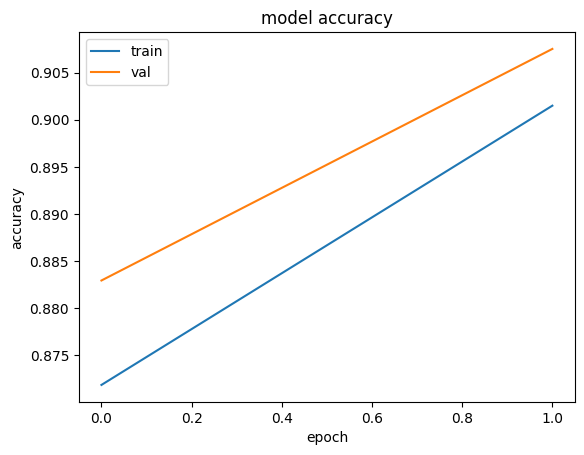

In [69]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

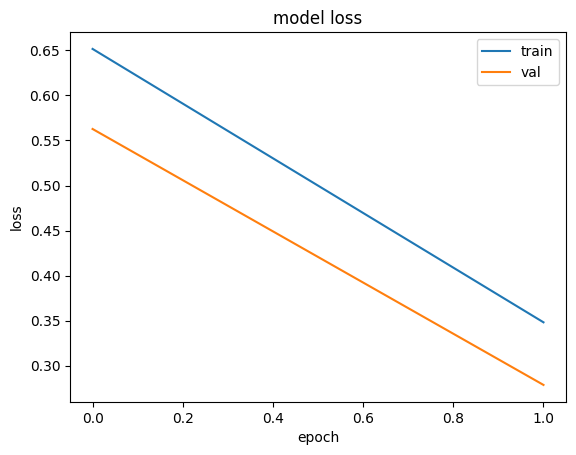

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [71]:
predictions = model.predict(X_test)
model.evaluate(X_test, Y_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 335ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 337ms/step - accuracy: 0.9148 - loss: 0.2670


[0.2785261869430542, 0.9075144529342651]

In [72]:
print(predictions[:10])
print(Y_test[:10])
print([len(x) for x in X_test[:10]])

[[0.0239324 ]
 [0.05615419]
 [0.07774204]
 [0.81385654]
 [0.91588324]
 [0.03876276]
 [0.04555387]
 [0.02178153]
 [0.84703124]
 [0.750237  ]]
5525    0
1235    0
2182    0
230     1
4830    1
2942    0
4594    0
2357    0
810     1
1297    1
Name: target, dtype: int64
[453, 167, 181, 29, 85, 485, 267, 425, 53, 167]


In [73]:
pred_probability = model.predict(X_test)
pred_classes = []
threshold = 0.5
for i in range(len(X_test)):
    if pred_probability[i][0] > threshold:
        res = 1
    else: res = 0
    pred_classes.append([res,Y_test.values[i]])

44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 389ms/step


In [74]:
TP = 0
FP = 0
TN = 0
FN = 0
for pred, res in pred_classes:
    if pred == 1:
        if res == 1:
            TP += 1
        else:
            FP += 1
    
    if pred == 0:
        if res == 0:
            TN += 1
        else:
            FN += 1

confusion_matrix = [[TP,FP],[FN,TP]]

print('TP:', TP)
print('FP:', FP)
print('TN:', TN)
print('FN:', FN)

TP: 606
FP: 61
TN: 650
FN: 67


In [75]:
def matthews_cor(conf_mat):
    n11 = conf_mat[0][0]/1000
    n10 = conf_mat[0][1]/1000
    n01 = conf_mat[1][0]/1000
    n00 = conf_mat[1][1]/1000
    return (n11*n00 - n10*n01) / (np.sqrt((n11+n10)*(n01+n00)*(n10+n00)*(n11+n01)))
    

matthews_cor(confusion_matrix)

0.8089914923667437

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Actual')]

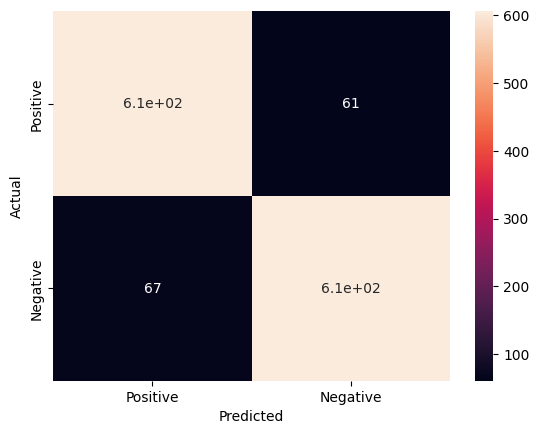

In [76]:
ax = sb.heatmap(confusion_matrix, annot=True, xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
ax.set(xlabel="Predicted", ylabel="Actual")

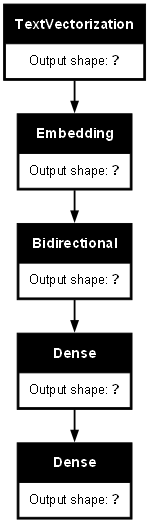

In [77]:
tf.keras.utils.plot_model(model, "LSTM_model.png", dpi=65, show_shapes=True)

In [81]:
model_json = model.to_json()
with open("Models\LTSM.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Models\LTSM.weights.h5")
print("Saved model to disk")

Saved model to disk
